Remeber to set RunTime type to GPU/TPU before u start



In [ ]:
#import necessary packages

import csv
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import torch
print(torch.__version__)
import nltk
from nltk.corpus import stopwords

drive.mount("/content/gdrive", force_remount=True)

1.13.0+cu116
Mounted at /content/gdrive


In [ ]:
#helper functions with tokenizing and cleaning up

import re  

#tokenizes a list of sentences: [str, str, str] --> [[str,str, str],[str, str, str], [str, str, str]]
def tokenize_list(l, tokenizer = lambda s: s.split()):
  output = list()
  for i in l:
    #print(tokenizer(i))
    output.append(tokenizer(i))
  return output

#removes any punctuations
def cleanup_text(texts):
    cleaned_text = []
    for text in texts:
        #remove punctuation
        text = re.sub('[^a-zA-Z0-9.]', ' ', text)
        # remove multiple spaces
        text = re.sub(r' +', ' ', text)
        # remove newline
        text = re.sub(r'\n', ' ', text)
        text = text.lower()
        # remove "Reuters" keyword
        text = re.sub(r'reuters', ' ', text)
        #remove "video" keyword
        text = re.sub(r'video', ' ', text)

        cleaned_text.append(text)
    return cleaned_text

In [ ]:
#glove_loader
def load_glove_embeddings(file_path: str) -> "dict[str, np.ndarray]":
    """
    Loads trained GloVe embeddings downloaded from:
        https://nlp.stanford.edu/projects/glove/
    """
    word_to_embedding = {}
    with open(file_path, "r") as f:
        for line in f:
            word, raw_embeddings = line.split()[0], line.split()[1:]
            embedding = np.array(raw_embeddings, dtype=np.float64)
            word_to_embedding[word] = embedding
    return word_to_embedding

In [ ]:
#loading data ... text_title concatenated with text_content
#scripts to load the ISOT data, X_total is a concatenation of X_real and X_fake, Y_total similar idea

with open('/content/gdrive/MyDrive/COMP 599 Project/Fake.csv', encoding='mac_roman') as csv_file:
  csv_reader = csv.reader(csv_file)
  colnames = next(csv_reader)  
  X_fake = []
  Y_fake = []
  for row in csv_reader: 
      X_fake.append(row[0]+ " " + row[1])
      Y_fake.append(1)

with open('/content/gdrive/MyDrive/COMP 599 Project/True.csv', encoding='mac_roman') as csv_file:
  csv_reader = csv.reader(csv_file)
  colnames = next(csv_reader)  
  X_real = []
  Y_real = []
  for row in csv_reader: 
      X_real.append(row[0] + " " + row[1])
      Y_real.append(0)

X_real = cleanup_text(X_real)
X_fake = cleanup_text(X_fake)

#the concatenated data (X_total is a list of strings, Y_total is a list of integers)
X_total = X_real + X_fake
Y_total = Y_real + Y_fake

In [ ]:
s = 0
n = 0
for article in X_total:
  s += len(article)
  n += 1
print(len(X_total))
print(s)
print(n)
print(s/n)

44898
112295861
44898
2501.132812151989


In [ ]:
counter = 0
for item in X_fake:
  if "video" in X_fake:
    counter += 1
  elif "Video" in X_fake:
    counter += 1
print(counter)

In [ ]:
#word clouds of the corpus
#Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
#Importing Dataset
df = pd.read_csv("/content/gdrive/MyDrive/COMP599 Dataset/Fake.csv")
df2 = pd.read_csv("/content/gdrive/MyDrive/COMP599 Dataset/True.csv")

print(df.shape[0])
print(df2.shape[0])

#df = pd.concat([df,df2], axis = 0)
df = df2

print(df.shape[0])
#Checking the Data
df.head()
#Checking for NaN values
df.isna().sum()
#Removing NaN Values
#df.dropna(inplace = True)
#Creating the text variable
text = " ".join(title for title in df.title)
text = cleanup_text([text])
text = text[0]

print(type(text))

# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

FileNotFoundError: ignored

In [ ]:
#word frequency from ISOT corpus
from collections import Counter
t = 'this is the textfile, and it is used to take words and count'

frequency_dict = dict(Counter(text.split()))

#sort this dictionary

frequency_dict = dict(sorted(frequency_dict.items(), key = lambda x: x[1], reverse = True))

#remove words with less than 3 length

for key in list(frequency_dict.keys()):
  if (len(key) <= 3):
    frequency_dict.pop(key)

print(list(frequency_dict.items())[:50])

frequencies = [x[1] for x in list(frequency_dict.items())[:10]]
labels = [x[0] for x in list(frequency_dict.items())[:10]]

print(frequencies)

import matplotlib.pyplot as plt

plt.bar(labels, frequencies)
plt.title("Word Frequency in ISOT Corpus (Real)")
plt.show()

In [ ]:
'''
#an analysis of the news titles determines that the following political words are suitable for the filter
#left: Hillary, Obama, Democrat, liberal, Clinton, socialism, socialist, communism, liberals, refugees, refugee
#right: trump, republican, donald, conservative, capitalism, capitalist, bush, mccain, conservatives, illegals, illegal

def political_sublist(texts, labels, target_keywords, anti_keywords):
  sublist = list()
  labellist = list()
  texts_copy = texts.copy()
  labels_copy = labels.copy()
  zipped = zip(texts_copy,labels_copy)
  for text,label in zipped:
    target_count = 0
    opponent_count = 0
    for w in target_keywords:
      if w in text:
        target_count += 1
    for w in anti_keywords:
      if w in text:
        opponent_count += 1
    if (target_count >= opponent_count):
      sublist.append(text)
      labellist.append(label)
      
  return sublist, labellist

#obtain lists of entries containing mainly left keywords

left_keywords = [ 'left','hillary', 'obama', 'democrat', 'liberal', 'clinton', 'socialism', 'socialist', 'communism', 'liberals', 'refugees', 'refugee']
right_keywords = ['right','trump', 'republican', 'donald', 'conservative', 'capitalism', 'capitalist', 'bush', 'mccain', 'conservatives', 'illegals', 'illegal']


left_list_real, left_labels_real = political_sublist(X_real, Y_real, left_keywords, right_keywords)
left_list_fake, left_labels_fake = political_sublist(X_fake, Y_fake, left_keywords, right_keywords)

#obtain a lists of entries containing mainly right keywords

right_list_real, right_labels_real = political_sublist(X_real, Y_real, right_keywords, left_keywords)
right_list_fake, right_labels_fake = political_sublist(X_fake, Y_fake, right_keywords, left_keywords)

#partition real and fake data into ratios
def partition(real_texts, real_labels, fake_texts, fake_labels, count = 10000, ratio = 4): #for every four real, we have 1 fake
  real_text_output = list()
  real_labels_output = list()

  fake_text_output = list()
  fake_labels_output = list()

  looper = list(zip(real_texts, real_labels))
  
  i = 1
  for (x,y) in looper:
    if (i%ratio == 0):
      fake_text_output.append(fake_texts.pop(int(i/ratio)))
      fake_labels_output.append(fake_labels.pop(int(i/ratio)))
    real_text_output.append(x)
    real_labels_output.append(y)
    if (i == count):
      break
      
    i += 1
  return real_text_output, real_labels_output, fake_text_output, fake_labels_output

#partition based on true/false ratio and build new list

real_left_x,  real_left_y, fake_left_x, fake_left_y = partition(left_list_real, left_labels_real, left_list_fake, left_labels_fake)
fake_right_x, fake_right_y, real_right_x,  real_right_y = partition(right_list_fake, right_labels_fake,right_list_real, right_labels_real)

In [ ]:
print(real_left_x[0])

fbi russia probe helped by australian diplomat tip off nyt washington   trump campaign adviser george papadopoulos told an australian diplomat in may 2016 that russia had political dirt on democratic presidential candidate hillary clinton the new york times reported on saturday. the conversation between papadopoulos and the diplomat alexander downer in london was a driving factor behind the fbi s decision to open a counter intelligence investigation of moscow s contacts with the trump campaign the times reported. two months after the meeting australian officials passed the information that came from papadopoulos to their american counterparts when leaked democratic emails began appearing online according to the newspaper which cited four current and former u.s. and foreign officials. besides the information from the australians the probe by the federal bureau of investigation was also propelled by intelligence from other friendly governments including the british and dutch the times sa

In [ ]:
#create the dataset object of the partitions
from torch.utils.data import DataLoader, Dataset
class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = torch.LongTensor(targets)
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y
    
    def __len__(self):
        return len(self.data)

import torch

from torch.utils.data import DataLoader, Dataset, random_split

from torch.optim import SGD

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#creates a dataset using X_total and Y_total
def create_dataset(X_total, Y_total, train_percentage = 0.7):

  dataset = CustomDataset(X_total, Y_total)

  subsets = random_split(dataset, [int(len(dataset)*train_percentage), len(dataset) - int(len(dataset)*train_percentage)], generator=torch.Generator().manual_seed(42))

  train_loader = DataLoader(subsets[0], batch_size = 64, shuffle = True)

  valid_loader = DataLoader(subsets[1], batch_size = 64, shuffle = False)

  print(len(subsets[0].indices))
  print(len(subsets[1].indices))

  return train_loader, valid_loader

train_loader, valid_loader = create_dataset(X_total, Y_total)

'''
#build a new dataset using the above:

X_total = real_left_x + real_right_x + fake_left_x + fake_right_x
Y_total = real_left_y + real_right_y + fake_left_y + fake_right_y

train_loader2, valid_loader2 = create_dataset(X_total, Y_total)
'''

31428
13470


'\n#build a new dataset using the above:\n\nX_total = real_left_x + real_right_x + fake_left_x + fake_right_x\nY_total = real_left_y + real_right_y + fake_left_y + fake_right_y\n\ntrain_loader2, valid_loader2 = create_dataset(X_total, Y_total)\n'

In [ ]:
'''
count_list = []
for batch in valid_loader2:
  for example in batch:
    left_count = 0
    right_count = 0
    for text in example:
      for word in text:
        print(word)

      for w in left_keywords:
        if w in text:
          left_count += 1
      for w in right_keywords:
        if w in text[0:-1]:
          right_count += 1
      count_list.append(left_count-right_count)

In [ ]:
ct = 0
cf = 0
for batch in train_loader:
  for t in batch[1]:
    if t.item() == 0:
      ct += 1
    else:
      cf += 1
print(ct/(cf+ct))
ct = 0
cf = 0
for batch in valid_loader:
  for t in batch[1]:
    if t.item() == 0:
      ct += 1
    else:
      cf += 1
print(ct/(cf+ct))

0.4740995290823469
0.4838158871566444


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-12-13 14:54:15--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-12-13 14:54:15--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-13 14:54:15--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!unzip '/content/gdrive/MyDrive/COMP 599 Project/glove.6B.zip'

Archive:  /content/gdrive/MyDrive/COMP 599 Project/glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
glove_embeddings = load_glove_embeddings("/content/glove.6B.300d.txt") 

In [ ]:
#time to load the glove_embeddings
#scripts to load GloVE as an numpy array part 1
vocab = list(glove_embeddings.keys())
embeddings = list(glove_embeddings.values())

#part 2
import numpy as np
vocab_npa = np.array(vocab)
embs_npa = np.array(embeddings)

#insert '<pad>' and '<unk>' tokens at start of vocab_npa.
vocab_npa = np.insert(vocab_npa, 0, '<pad>')
vocab_npa = np.insert(vocab_npa, 1, '<unk>')
print(vocab_npa[:10])

pad_emb_npa = np.zeros((1,embs_npa.shape[1]))   #embedding for '<pad>' token.
unk_emb_npa = np.mean(embs_npa,axis=0,keepdims=True)    #embedding for '<unk>' token.

#insert embeddings for pad and unk tokens at top of embs_npa.
embs_npa = np.vstack((pad_emb_npa,unk_emb_npa,embs_npa))
print(embs_npa.shape)

#testing code, not too important
import torch
debiased_my_embedding_layer = torch.nn.Embedding.from_pretrained(torch.from_numpy(embs_npa).float())

assert debiased_my_embedding_layer.weight.shape == embs_npa.shape
print(debiased_my_embedding_layer.weight.shape)

#word_to_idx is a global variable, which maps a word (str) --> index (integer)
word_to_idx = dict()
for i in range(len(vocab_npa)):
  word_to_idx[vocab_npa[i]] = i

['<pad>' '<unk>' 'the' ',' '.' 'of' 'to' 'and' 'in' 'a']
(400002, 300)
torch.Size([400002, 300])


In [ ]:
#helper functions for CustomBiLSTM_glove, preprocessing sentences
import torch.nn as nn
#converts a list of words into a list of idx
def convert_to_idx(sentence, word_to_idx):

  row = np.array([])
  for word in sentence:
    try:
      row = np.hstack((row, word_to_idx[word]))
    except KeyError as e:
      #unknown token
      row = np.hstack((row, 1))
  
  return row

#convert a list of tokenized sentences (list of list of words) into a (list of list of idx)

def sentences_to_idx(sentences, word_to_idx):

  output = list()
  for sentence in sentences:
    row = convert_to_idx(sentence, word_to_idx)
    #print(row)
    output.append(row)

  

  return output

#converts a list of idx into a list of idx but padded

def padding_sentences(batch_sentences):

  lengths = [len(x) for x in batch_sentences]

  batch_sentences = [torch.tensor(x) for x in batch_sentences]

  padded = nn.utils.rnn.pad_sequence(batch_sentences ,batch_first = True)

  return padded, lengths


#an example of preprocessing:
sentences = ("hello there","good")
sentences = tokenize_list(sentences)

idx = sentences_to_idx(sentences, word_to_idx)

padded_idx, lengths = padding_sentences(idx)

print(lengths)

#test what embedding looks like

[2, 1]


In [ ]:
#pretty much the same, except you pass in an embedding dictionary (arg = glove_embeddings)
#model 2
class CustomBiLSTM_glove(nn.Module):
  def __init__(self, glove_embeddings, input_size, hidden_size, num_layers, linear_dim, num_classes = 2):
    super().__init__()

    self.embedding_layer = glove_embeddings
    #freeze the embedding_layer
    self.embedding_layer.requires_grad = False
    
    self.biLSTM = nn.LSTM(input_size, hidden_size, num_layers, bidirectional = True, batch_first = True)

    self.linear1 = nn.Linear(hidden_size, linear_dim)

    self.linear2 = nn.Linear(linear_dim, num_classes)

    self.activation = nn.ReLU()

    self.softmax = nn.Softmax(dim=1)

  #input is a list of padded indices (sentences)
  def forward(self, sentences, sentence_lengths):

    embedded = self.embedding_layer(sentences)

    #print(self.embedding_layer.weight)

    packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, sentence_lengths, batch_first = True, enforce_sorted = False)

    output, (h_n, c_n) = self.biLSTM(packed)

    #obtain the output
    c_n = torch.mean(c_n, dim=0)

    output = self.linear1(c_n)

    output = self.activation(output)

    output = self.linear2(output)

    output = self.softmax(output)

    return output

In [ ]:
#training function
from torch.nn.functional import one_hot
from sklearn.metrics import accuracy_score
from torch.nn import BCELoss
import time
from statistics import mean

def train_glove(input_model, word_to_idx, data_loader, optimizer, num_epochs = 100, valid = None):

  model = input_model
  
  

  num_epochs = num_epochs

  curr_epoch = 0
  
  accuracy_per_epoch = []
  loss_per_epoch = []
  val_results_per_epoch = []

  model.train()

  for epoch in range(num_epochs):
    running_loss = []
    n = 0
    accuracy = 0
    model.train()
    start = time.time()
    for x in data_loader:

      X_tokens = tokenize_list(x[:][0])

      #padding step
      idx = sentences_to_idx(X_tokens, word_to_idx)

      padded_idx, lengths = padding_sentences(idx)

      #print((padded_idx).size())
      #print(len(lengths))
      
      predictions = model.forward(padded_idx.type(torch.LongTensor).to(device), lengths)

      #print(predictions.size())

      true_labels = one_hot(torch.tensor(x[:][1]).to(device),num_classes = 2).float()
      #print(true_labels.size())
      #print(true_labels)

      lossfn = BCELoss()

      loss = lossfn(predictions, true_labels)

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

      curr_score =  accuracy_score(predictions.cpu().detach().round(), true_labels.cpu().detach())

      accuracy += curr_score
      running_loss.append(loss.item())
      n += 1
    end = time.time()    
    
    print(f"epoch {curr_epoch}: training loss {mean(running_loss):.8f}")

    print(f"training accuracy {(accuracy/n):.8f}")
    accuracy_per_epoch.append(accuracy/n)
    loss_per_epoch.append(mean(running_loss))

    print(f"time elapsed: {(end-start):.2f} seconds")

    if valid != None:
      with torch.no_grad():
        val_results = evaluate_glove(model,valid, word_to_idx)
        print(f"validation loss:{val_results[4]:.8f}")
        print(f"validation accuracy: {val_results[0]:.8f}")
        val_results_per_epoch.append(val_results)
    print("====================================")
    curr_epoch += 1
  return model, accuracy_per_epoch, loss_per_epoch, val_results_per_epoch

#evaluation fns for CustomBiLSTM_glove
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from torch.nn import BCELoss
from statistics import mean

def evaluate_glove(model, loader, w2i):
  model.eval()
  score = 0
  precision = 0
  recall = 0
  f1 = 0
  n = 0
  loss = []

  for entry in loader:
    X_tokens = tokenize_list(entry[:][0])

    #padding step
    idx = sentences_to_idx(X_tokens, w2i)

    padded_idx, lengths = padding_sentences(idx)

    #print((padded_idx).size())
    #print(len(lengths))
    
    predictions = model.forward(padded_idx.type(torch.LongTensor).to(device), lengths)

    #print(predictions)

    predictions = predictions.round()

    true_labels = one_hot(torch.tensor(entry[:][1]).to(device),num_classes = 2).float()

    #print(predictions)
    #print(true_labels)
    lossfn = BCELoss()

    curr_loss = lossfn(predictions, true_labels)

    curr_precision, curr_recall, curr_f1, curr_support = precision_recall_fscore_support(predictions.cpu().detach(), true_labels.cpu().detach())

    curr_score =  accuracy_score(predictions.cpu().detach(), true_labels.cpu().detach())
    # print("updating score...")
    # print(curr_score)

    loss.append(curr_loss.item())
    score += curr_score
    precision += curr_precision
    recall += curr_recall
    f1 += curr_f1

    n += 1

  return score/n, precision/n, recall/n, f1/n, mean(loss)

def predict_glove(model, sentences, w2i):
  model.eval()

  X_tokens = tokenize_list(sentences)

  #padding step
  idx = sentences_to_idx(X_tokens, w2i)

  padded_idx, lengths = padding_sentences(idx)

  #print((padded_idx).size())
  #print(len(lengths))
  
  predictions = model.forward(padded_idx.type(torch.LongTensor).to(device), lengths)

  #print(predictions.size())

  #print(predictions)

  return torch.argmax(predictions, dim=1)

In [ ]:
political_attribute_words = [ ["democrat","republican"] , ["democrats","republicans"]  , ["liberal","conservative"] , ["liberals","conservatives"] , 
                             ["obama","mccain"] , ["kerry","bush"] , ["liberalism","conservatism"] , ["communism","capitalism"] , ["refugee","illegal"] ,
                             ["refugees","illegals"] , ["blue","red"] , ["globalist","isolationist"] , ['globalism','isolationism'] , ['obama','trump'] , 
                             ['clinton' , 'trump'], ['hillary','donald']]

In [ ]:
from sklearn.decomposition import PCA
def compute_political_subspace(
    word_to_embedding: "dict[str, np.array]",
    political_attribute_words: "list[list[str, str]]",
    n_components: int = 1,
) -> np.array:
    pol_emb = list() 
    for x in political_attribute_words:
        pol_emb.append([word_to_embedding[x[0]],word_to_embedding[x[1]]])
    for l in pol_emb:
        mean = (l[0]+l[1])/2
        l[0] = l[0] - mean
        l[1] = l[1] - mean
    pol_emb = np.array(pol_emb)
    pol_emb = pol_emb.reshape(-1, pol_emb.shape[-1])
    pca = PCA(n_components)
    pca.fit(pol_emb)
    return pca.components_


def project(a: np.array, b: np.array) -> "tuple[float, np.array]":
    numer = np.dot(a,b)
    denom = np.dot(b,b)
    scalar = np.divide(numer,denom)
    vector_projection = np.multiply(scalar,b)
    return scalar, vector_projection

def debias_word_embedding(
    word: str, word_to_embedding: "dict[str, np.array]", political_subspace: np.array
) -> np.array:
    word_emb = word_to_embedding[word]
    for i in range(political_subspace.shape[0]):
            s, projection = project(word_emb,political_subspace[i])

    debiased_embedding = np.subtract(word_emb,projection)

    return debiased_embedding

def hard_debias(
    word_to_embedding: "dict[str, np.array]",
    political_attribute_words: "list[list[str]]",
    n_components: int = 1) -> "dict[str, np.array]":
    gender_subspace = compute_political_subspace(word_to_embedding, political_attribute_words, n_components)
    all_words = list(word_to_embedding.keys())
    debiased_embeddings = list()
    for word in all_words:
        debiased_embeddings.append(debias_word_embedding(word,word_to_embedding,gender_subspace))
   
    dicts = {}
    for i,x in enumerate(all_words):
        dicts[x] = debiased_embeddings[i]
    
    return dicts

In [ ]:
political_subspace = compute_political_subspace(glove_embeddings,political_attribute_words)

In [ ]:
debiased_embeddings = hard_debias(glove_embeddings, political_attribute_words)

In [ ]:
vocabs = list(debiased_embeddings.keys())
embeddingss = list(debiased_embeddings.values())

In [ ]:
import numpy as np
vocab_npas = np.array(vocabs)
embs_npas = np.array(embeddingss)

#insert '<pad>' and '<unk>' tokens at start of vocab_npa.
vocab_npas = np.insert(vocab_npas, 0, '<pad>')
vocab_npas = np.insert(vocab_npas, 1, '<unk>')
print(vocab_npas[:10])

pad_emb_npas = np.zeros((1,embs_npas.shape[1]))   #embedding for '<pad>' token.
unk_emb_npas = np.mean(embs_npas,axis=0,keepdims=True)    #embedding for '<unk>' token.

#insert embeddings for pad and unk tokens at top of embs_npa.
embs_npas = np.vstack((pad_emb_npas,unk_emb_npas,embs_npas))
print(embs_npas.shape)

#DEBIASED GLOVE
import torch
debiased_my_embedding_layers = torch.nn.Embedding.from_pretrained(torch.from_numpy(embs_npas).float())

assert debiased_my_embedding_layers.weight.shape == embs_npas.shape
print(debiased_my_embedding_layers.weight.shape)

#word_to_idx is a global variable, which maps a word (str) --> index (integer)
word_to_idxs = dict()
for i in range(len(vocab_npas)):
  word_to_idxs[vocab_npas[i]] = i

['<pad>' '<unk>' 'the' ',' '.' 'of' 'to' 'and' 'in' 'a']
(400002, 300)
torch.Size([400002, 300])


In [ ]:
model_glove = CustomBiLSTM_glove(debiased_my_embedding_layer.to(device), 300,50,2,100).to(device)
optimizer = torch.optim.SGD(model_glove.parameters(), lr=0.01)

In [ ]:
checkpoint = torch.load('/content/gdrive/MyDrive/COMP 599 Project/biased_model.pth')
model_glove.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
debiased_model = CustomBiLSTM_glove(debiased_my_embedding_layers.to(device), 300,50,2,100).to(device)
debiased_optimizer = torch.optim.SGD(model_glove.parameters(), lr=0.01)

In [ ]:
debiased_checkpoint = torch.load('/content/gdrive/MyDrive/COMP 599 Project/debiased_model.pth')
debiased_model.load_state_dict(debiased_checkpoint['model_state_dict'])
debiased_optimizer.load_state_dict(debiased_checkpoint['optimizer_state_dict'])

In [ ]:
import warnings
warnings.filterwarnings('ignore')
for batch in valid_loader:
    b = False
    X_tokens = tokenize_list(batch[:][0])
    idx = sentences_to_idx(X_tokens, word_to_idx)
    padded_idx, lengths = padding_sentences(idx)
    #
    biased_predictions = model_glove.forward(padded_idx.type(torch.LongTensor).to(device), lengths)
    biased_predictions = biased_predictions.round()
    #
    debiased_predictions = debiased_model.forward(padded_idx.type(torch.LongTensor).to(device), lengths)
    debiased_predictions = debiased_predictions.round()
    #
    true_labels = one_hot(torch.tensor(batch[:][1]).to(device),num_classes = 2).float()
    #
    # i = 3
    # print(biased_predictions[i].tolist())
    # print(debiased_predictions[i].tolist())
    # print(true_labels[i].tolist())
    # print(batch[0][i])
    for i in range(len(predictions.tolist())):
      if (biased_predictions[i].tolist() == true_labels[i].tolist()) and (debiased_predictions[i].tolist() == true_labels[i].tolist()):
        b = True
        print(biased_predictions[i].tolist())
        print(debiased_predictions[i].tolist())
        print(true_labels[i].tolist())
        print(batch[0][i])
        break
    if b == True:
      break

[0.0, 1.0]
[0.0, 1.0]
[0.0, 1.0]
all whites in back democrats prove their obsession with race in one ridiculous photo nothing says embracing diversity like dividing interns by color and kicking the white interns to the back of the photo.it s pretty fitting that the race obsessed us rep. from texas sheila jackson lee would post such a telling photo on twitter the democratic interns on capitol hill 2016 deminternselfie pic.twitter.com zzuml4hkoc sheila jackson lee jacksonleetx18 july 20 2016the photo of dem interns was supposed to be in response to a paul ryan selfie that the democrats who can never see past the color of one s skin posted to show how much more diverse they are.so diversity is kicking white interns to the back of the photo h t weasel zipperssomething about this picture is eerily similar to the picture taken of the crowd taken that exposed the segregation of women and men during london s new muslim mayor sadiq khan s speech on the benefits of britain sticking with the eu. 

In [ ]:
#training cell, with the original embeddings
import warnings
warnings.filterwarnings('ignore')
model_glove = CustomBiLSTM_glove(debiased_my_embedding_layer.to(device), 300,50,2,100).to(device)
optimizer = torch.optim.SGD(model_glove.parameters(), lr=0.01)
o_model, o_a, o_loss, validation_results = train_glove(model_glove, word_to_idx, train_loader, optimizer, 5, valid = valid_loader)

epoch 0: training loss 0.68285521
training accuracy 0.55694233
time elapsed: 137.70 seconds
validation loss:34.17555293
validation accuracy: 0.65824447
epoch 1: training loss 0.62942248
training accuracy 0.78242505
time elapsed: 136.94 seconds
validation loss:13.46958926
validation accuracy: 0.86530411
epoch 2: training loss 0.44675806
training accuracy 0.89186357
time elapsed: 137.82 seconds
validation loss:9.41795025
validation accuracy: 0.90582050
epoch 3: training loss 0.25053283
training accuracy 0.91955666
time elapsed: 137.35 seconds
validation loss:7.70438389
validation accuracy: 0.92295616
epoch 4: training loss 0.17566839
training accuracy 0.93607088
time elapsed: 137.27 seconds
validation loss:6.28357030
validation accuracy: 0.93716430


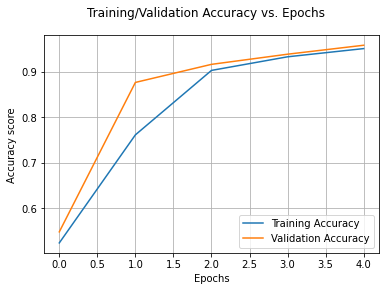

In [ ]:
plt.plot(np.arange(0,len(o_a)),o_a) 
plt.plot(np.arange(0,len(o_a)), [x[0] for x in validation_results])
plt.suptitle("Training/Validation Accuracy vs. Epochs")
plt.legend(["Training Accuracy", "Validation Accuracy"], loc ="best")
plt.xlabel("Epochs")
plt.ylabel("Accuracy score")
plt.grid(True)
plt.show()

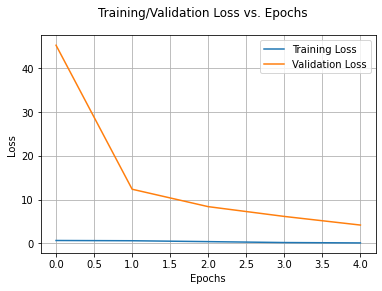

In [ ]:
plt.plot(np.arange(0,len(o_a)),o_loss) 
plt.plot(np.arange(0,len(o_a)), [x[4] for x in validation_results])
plt.suptitle("Training/Validation Loss vs. Epochs")
plt.legend(["Training Loss", "Validation Loss"], loc ="best")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [ ]:
import warnings
warnings.filterwarnings('ignore')
with torch.no_grad():
  valid_results = evaluate_glove(model_glove,valid_loader, word_to_idx)
# for item in valid_loader2:
#   print((item[0][0]))
#   print(predict_glove(model_glove,[item[0][0]], word_to_idx))
#   print(item[1][0])
#   break
print("Accuracy:")
print(valid_results[0])
print("precision,recall,f1")
from statistics import mean
for i in range(1,4):
  print(mean(valid_results[i]))
print("Loss")
print(valid_results[4])

Accuracy:
0.9375
precision,recall,f1
0.9375782958303236
0.9378312999378188
0.9366275663113004
Loss
6.25


In [ ]:
torch.save({ 'model_state_dict': model_glove.state_dict(), 
            'optimizer_state_dict': optimizer.state_dict()
            },'/content/gdrive/MyDrive/COMP 599 Project/biased_model.pth')

In [ ]:
model_glove = CustomBiLSTM_glove(debiased_my_embedding_layer.to(device), 300,50,2,100).to(device)
optimizer = torch.optim.SGD(model_glove.parameters(), lr=0.01)

In [ ]:
checkpoint = torch.load('/content/gdrive/MyDrive/COMP 599 Project/biased_model.pth')
model_glove.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
print(accuracy_score)

0.9769597457627118


In [ ]:
import torch.nn.functional as F
from typing import Union, Callable
def cosine_similarity(a: np.array, b: np.array) -> float:
    # TODO: your work here
    a_tensor = torch.from_numpy(a)
    b_tensor = torch.from_numpy(b)
    return (F.cosine_similarity(a_tensor,b_tensor,0).item())


def compute_direct_bias(
    words: "list[str]",
    word_to_embedding: "dict[str, np.array]",
    gender_subspace: np.array,
    c: float = 0.25,
):
    # TODO: your work here
    word_emb = list()
    for word in words:
        word_emb.append(word_to_embedding[word])
    
    cos_list = list()
    for i in range(gender_subspace.shape[0]):
        for j in range(len(word_emb)):
            cos = cosine_similarity(word_emb[j],gender_subspace[i])
            cos_list.append(cos)
    
    abs_cos_list = [pow(abs(ele),c) for ele in cos_list]
    sum_cos = sum(abs_cos_list)
    direct_bias = sum_cos/len(words)
    return direct_bias


def weat_association(
    w: str, A: "list[str]", B: "list[str]", word_to_embedding: "dict[str, np.array]"
) -> float:
    # TODO: your work here
    w_emb = word_to_embedding[w]
    A_emb = list()
    B_emb = list()
    for word in A:
        A_emb.append(word_to_embedding[word])
    for word in B:
        B_emb.append(word_to_embedding[word])
    
    mean_cos_a = np.mean([cosine_similarity(w_emb,att_emb) for att_emb in A_emb])
    mean_cos_b = np.mean([cosine_similarity(w_emb,att_emb) for att_emb in B_emb])
    weat = mean_cos_a - mean_cos_b

    return weat


def weat_differential_association(
    X: "list[str]",
    Y: "list[str]",
    A: "list[str]",
    B: "list[str]",
    word_to_embedding: "dict[str, np.array]",
    weat_association_func: Callable,
) -> float:
    # TODO: your work here

    diff_association_x = np.sum([weat_association_func(i,A,B,word_to_embedding) for i in X]) 
    diff_association_y = np.sum([weat_association_func(i,A,B,word_to_embedding) for i in Y])

    diff_association = diff_association_x - diff_association_y 
    
    return diff_association

In [ ]:
political_attribute_words = [ ["democrat","republican"] , ["democrats","republicans"]  , ["liberal","conservative"] , ["liberals","conservatives"] , 
                             ["obama","mccain"] , ["kerry","bush"] , ["liberalism","conservatism"] , ["communism","capitalism"] , ["refugee","illegal"] ,
                             ["refugees","illegals"] , ["blue","red"] , ["globalist","isolationist"] , ['globalism','isolationism'] , ['obama','trump'] , 
                             ['hillary' , 'trump']]

In [ ]:
from sklearn.decomposition import PCA
def compute_political_subspace(
    word_to_embedding: "dict[str, np.array]",
    political_attribute_words: "list[list[str, str]]",
    n_components: int = 1,
) -> np.array:
    pol_emb = list() 
    for x in political_attribute_words:
        pol_emb.append([word_to_embedding[x[0]],word_to_embedding[x[1]]])
    for l in pol_emb:
        mean = (l[0]+l[1])/2
        l[0] = l[0] - mean
        l[1] = l[1] - mean
    pol_emb = np.array(pol_emb)
    pol_emb = pol_emb.reshape(-1, pol_emb.shape[-1])
    pca = PCA(n_components)
    pca.fit(pol_emb)
    return pca.components_

In [ ]:
neutral_words = ['politician' , 'diplomat', 'president' , 'senator' , 'centrist' , 'moderate']

In [ ]:
political_subspace = compute_political_subspace(glove_embeddings, political_attribute_words)

In [ ]:
compute_direct_bias(neutral_words, glove_embeddings, political_subspace)

0.6957276872225288